<h1><center>Task 1</center></h1>

## Table of Contents

* [Chapter 1](#chapter1): Data Cleaning
* [Chapter 2](#chapter2): Data Exploration
* [Chapter 3](#chapter3): Feature Engineering

In [1]:
#Importing libraries

#Data processing
import pandas as pd
import numpy as np
from numpy.random import seed
import re
import datetime as datetime
from datetime import date
import numbers

#Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

#Data modeling
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingRegressor, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, RobustScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.xgbod import XGBOD
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from skfeature.function.similarity_based import fisher_score
from sklearn.metrics import r2_score
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE

#Other
import warnings
pio.renderers.default = "notebook"

In [2]:
#Suppressing warnings
warnings.simplefilter(action = "ignore")

In [3]:
#Setting random seed
seed(11)

In [4]:
#Importing data
xtrain_df = pd.read_csv("X_train.csv", index_col = 0)
ytrain_df = pd.read_csv("y_train.csv", index_col = 0)
xtest_df = pd.read_csv("X_test.csv", index_col = 0)

In [5]:
feature_columns = xtrain_df.columns.to_list()

In [6]:
#Set params
params = {
    "random_state": 11,
    # Missing values
    "missing_values_imputation_method": "mean", #probably mean (0.59) or KNN (0.57)
    # Outliers
    "outlier_removal_method": "svm", #probably not iqr
    # Feature selection
    "feature_selection_method": "lasso", 
    # Scaling
    "scaling_method": "std", 
}

In [7]:
#To do: Add hyperparameters

## Chapter 1: <a class="anchor" id="chapter1"></a> Data Cleaning

### Columns

In [8]:
#Dropping columns with constants
constant_column_mask = xtrain_df.nunique() == 1
constants = constant_column_mask[constant_column_mask].index.to_list()
print(constants)

for constant in constants:
    xtrain_df = xtrain_df.drop(constant, axis = 1)
    xtest_df = xtest_df.drop(constant, axis = 1)
    feature_columns.remove(constant)

['x104', 'x129', 'x489', 'x530']


### Missing values

In [9]:
#Removing rows with null y values
print(len(ytrain_df))
mask = ~ytrain_df["y"].isna()
ytrain_df = ytrain_df[mask]
xtrain_df = xtrain_df[mask]
xtest_df = xtest_df[mask]
print(len(ytrain_df))

1212
1212


In [10]:
#Checking share of missing values
share_missing_vals_num = (xtrain_df.isnull().sum() / len(xtrain_df))
share_missing_vals_df = pd.DataFrame({"share_of_missing_values": share_missing_vals_num})
share_missing_vals_df = share_missing_vals_df.sort_values(by = "share_of_missing_values", ascending = False)
share_missing_vals_df

,share_of_missing_values
x79,0.099835
x381,0.098185
x734,0.097360
x313,0.097360
x463,0.096535
...,...
x84,0.056931
x728,0.056106
x425,0.056106
x151,0.054455


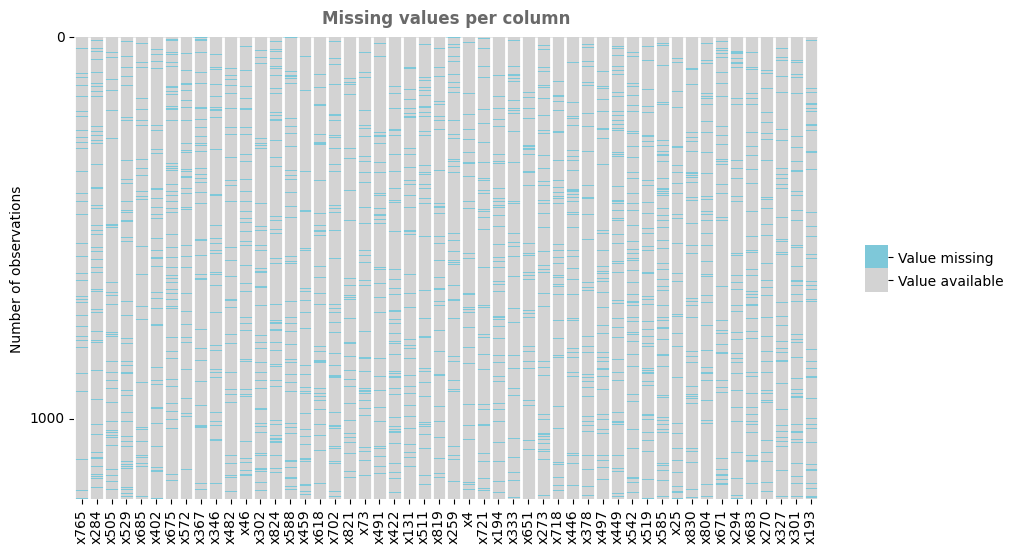

In [11]:
#Visualizing missing values
#Values seem to be missing at random
df_col_sample = xtrain_df.sample(axis=1,n=50)

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 6))

#Plotting
colors = ["lightgrey", "#7ec8d9"]
columns = [name for name in df_col_sample.columns]
ax = sns.heatmap(df_col_sample.isnull(), 
                 cmap = sns.color_palette(colors), 
                 cbar_kws = dict(
                     orientation = "vertical", 
                     shrink = 0.1,
                     aspect = 2.0))

#Setting parameters
ax.set_yticks(range(0, len(df_col_sample), 1000))
ax.set_yticklabels(range(0, len(df_col_sample), 1000))
ax.set_ylabel("Number of observations")
ax.set_xticklabels(columns)
ax.vlines(range(len(df_col_sample.columns) + 1), 
          ymin = 0, 
          ymax = len(df_col_sample) - 1, 
          color = "white", 
          linewidth = 2)
ax.set_title("Missing values per column",
             color = "#696969",
             weight = "bold",
             size = 12, 
             pad = 10)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(["Value available", "Value missing"])

In [12]:
#Filling missing values
def missing_value_imputation(X_train, X_test, params):
    if params['missing_values_imputation_method'] == 'median':
        X_train_imp = np.where(np.isnan(np.array(X_train)), np.nanmedian(np.array(X_train), axis = 0), np.array(X_train))
        X_test_imp = np.where(np.isnan(np.array(X_test)), np.nanmedian(np.array(X_test), axis = 0), np.array(X_test))
    
    elif params['missing_values_imputation_method'] == 'mean':
        X_train_imp = np.where(np.isnan(np.array(X_train)), np.nanmean(np.array(X_train), axis = 0), np.array(X_train))
        X_test_imp = np.where(np.isnan(np.array(X_test)), np.nanmean(np.array(X_test), axis = 0), np.array(X_test))
    
    elif params['missing_values_imputation_method'] == 'knn':
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        imputed_values_train = imputer.fit_transform(X_train)
        imputed_values_test = imputer.transform(X_test)
        X_train_imp = np.where(np.isnan(X_train), imputed_values_train, X_train)
        X_test_imp = np.where(np.isnan(X_test), imputed_values_test, X_test)
    
    elif params['missing_values_imputation_method'] == 'mice':
        imputer = IterativeImputer(max_iter=2, initial_strategy='median',n_nearest_features=5)
        imputed_values_train = imputer.fit_transform(X_train)
        imputed_values_test = imputer.transform(X_test)
        X_train_imp = np.where(np.isnan(X_train), imputed_values_train, X_train)
        X_test_imp = np.where(np.isnan(X_test), imputed_values_test, X_test)
    
    X_train = pd.DataFrame(X_train_imp, index = X_train.index, columns = X_train.columns)
    X_test = pd.DataFrame(X_test_imp, index = X_test.index, columns = X_test.columns)
        
    return X_train, X_test

In [13]:
#Filling missing values
xtrain_df, xtest_df = missing_value_imputation(xtrain_df, xtest_df, params)

### Outliers

In [14]:
#Checking share of numeric outliers
#No column with share of outliers > 12%
q1 = xtrain_df.quantile(0.25)
q3 = xtrain_df.quantile(0.75)
iqr = q3 - q1
share_outliers_num = (((xtrain_df < (q1 - 1.5 * iqr)) | (xtrain_df > (q3 + 1.5 * iqr))).sum() / len(xtrain_df))
share_outliers_df = pd.DataFrame({"share_of_outliers": share_outliers_num})
share_outliers_df = share_outliers_df.sort_values(by = "share_of_outliers", ascending = False)
share_outliers_df = share_outliers_df[share_outliers_df["share_of_outliers"]>0]
share_outliers_df

,share_of_outliers
x115,0.134488
x143,0.121287
x742,0.115512
x641,0.099010
x415,0.090759
...,...
x371,0.006601
x488,0.006601
x145,0.005776
x393,0.004950


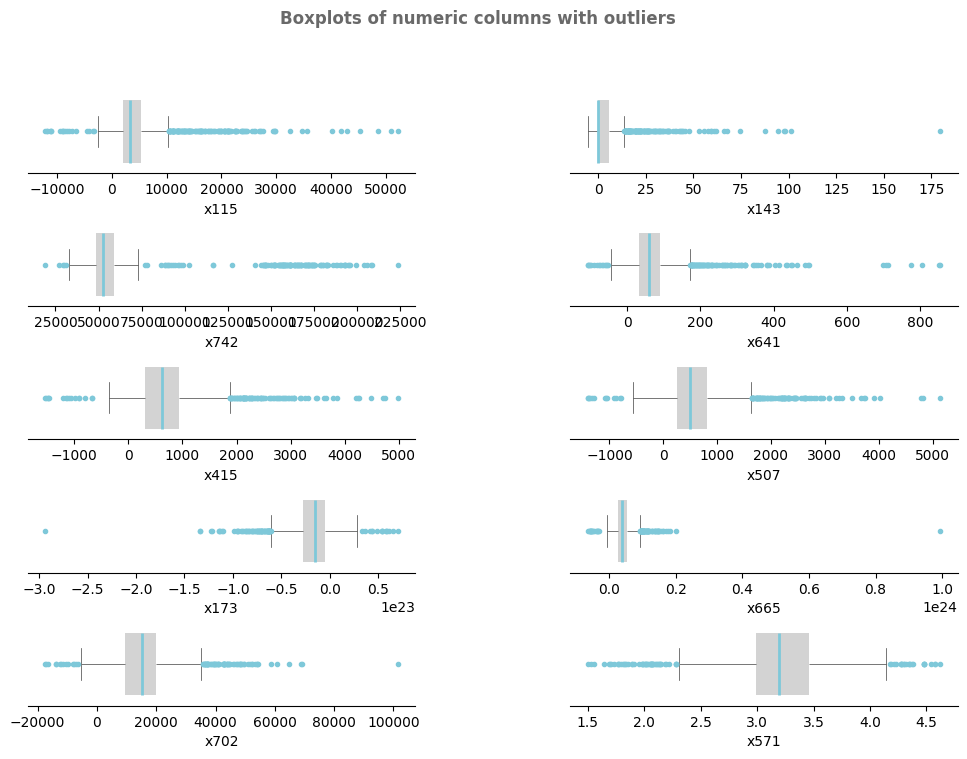

In [15]:
#Visualizing columns with most outliers
#Creating list
numeric_outlier_list = list(share_outliers_df[share_outliers_df["share_of_outliers"] > 0.05].index)

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 8), ncols = 2, nrows = 5)
fig.subplots_adjust(hspace = 0.6, wspace = 0.4)
sns.despine(left = True)
fig.suptitle("Boxplots of numeric columns with outliers",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
for column, axis in zip(numeric_outlier_list, ax.flat):
    sns.boxplot(x = column, 
                data = xtrain_df, 
                ax = axis, 
                linewidth = 0.75, 
                width = 0.75,
                medianprops = {"color":"#7ec8d9", 
                               "linewidth":2},
                flierprops = {"marker":"o", 
                              "markerfacecolor":"#7ec8d9", 
                              "markersize":3, 
                              "markeredgecolor":"#7ec8d9"},
                boxprops = {"linewidth":0, 
                            "facecolor":"lightgrey"},
                whiskerprops = {"linewidth":0.5, 
                                "markerfacecolor":"#565656"},
                capprops = {"linewidth":0.5, 
                            "markerfacecolor":"#565656"})
    axis.set_yticks([])
    axis.set_xlabel(column)

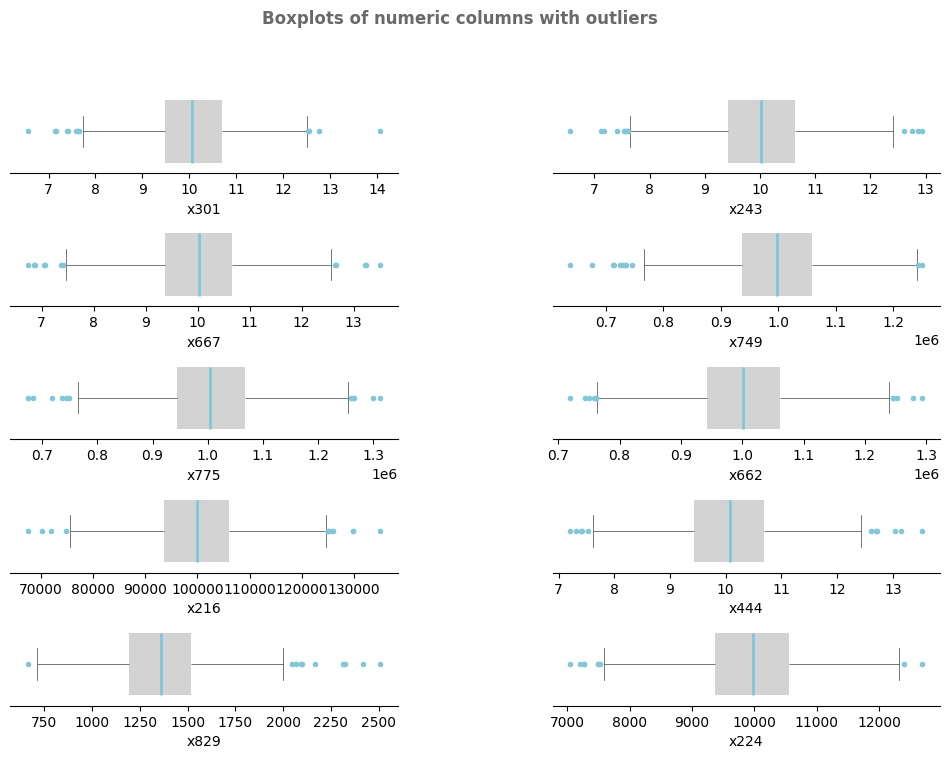

In [16]:
#Visualizing columns with least outliers
#Creating list
numeric_outlier_list = list(share_outliers_df[share_outliers_df["share_of_outliers"] < 0.01].index)

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 8), ncols = 2, nrows = 5)
fig.subplots_adjust(hspace = 0.6, wspace = 0.4)
sns.despine(left = True)
fig.suptitle("Boxplots of numeric columns with outliers",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
for column, axis in zip(numeric_outlier_list, ax.flat):
    sns.boxplot(x = column, 
                data = xtrain_df, 
                ax = axis, 
                linewidth = 0.75, 
                width = 0.75,
                medianprops = {"color":"#7ec8d9", 
                               "linewidth":2},
                flierprops = {"marker":"o", 
                              "markerfacecolor":"#7ec8d9", 
                              "markersize":3, 
                              "markeredgecolor":"#7ec8d9"},
                boxprops = {"linewidth":0, 
                            "facecolor":"lightgrey"},
                whiskerprops = {"linewidth":0.5, 
                                "markerfacecolor":"#565656"},
                capprops = {"linewidth":0.5, 
                            "markerfacecolor":"#565656"})
    axis.set_yticks([])
    axis.set_xlabel(column)

In [17]:
#Dropping outliers
def outlier_removal(X_train, y_train, params):
    if params['outlier_removal_method'] == 'iqr':
        q1 = xtrain_df.quantile(0.25)
        q3 = xtrain_df.quantile(0.75)
        iqr = q3 - q1
        mask = (xtrain_df < (q1 - 10 * iqr)) | (xtrain_df > (q3 + 10 * iqr))
        outlier_mask = mask.max(axis=1)
    
    elif params['outlier_removal_method'] == 'if':
        model = IForest(contamination=0.1, n_estimators=100, max_samples=0.9, max_features=0.9)
        model.fit(xtrain_df)
        outlier_mask = model.predict(xtrain_df)
        outlier_mask = outlier_mask == 1
        
    elif params['outlier_removal_method'] == 'md':
        X_train_a = np.array(xtrain_df)

        mean_vec = np.mean(X_train_a, axis=0)
        cov_matrix = np.cov(X_train_a, rowvar=False)
        inv_cov_matrix = np.linalg.inv(cov_matrix)

        def mahalanobis_distance(x, mean_vec, inv_cov_matrix):
            diff = x - mean_vec
            return np.sqrt(np.dot(np.dot(diff, inv_cov_matrix), diff.T))

        m_distances = np.array([mahalanobis_distance(x, mean_vec, inv_cov_matrix) for x in X_train_a])
        
        threshold = np.sqrt(chi2.ppf(0.95, df=X_train.shape[1]))
        outlier_mask = m_distances > threshold
    
    elif params['outlier_removal_method'] == 'svm':
        X_train_a = np.array(xtrain_df)

        ocsvm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
        ocsvm.fit(X_train_a)
        predictions = ocsvm.predict(X_train_a)

        outlier_mask = predictions == -1
    
    elif params['outlier_removal_method'] == 'pca':
        X_train_a = np.array(xtrain_df)

        pca = PCA(n_components=2)
        X_train_pca = pca.fit_transform(X_train_a)
        X_train_reconstructed = pca.inverse_transform(X_train_pca)
        reconstruction_error = np.mean((X_train - X_train_reconstructed) ** 2, axis=1)

        threshold = np.percentile(reconstruction_error, 95)
        outlier_mask = reconstruction_error > threshold

    X_train_cleaned = pd.DataFrame(X_train[~outlier_mask],index=X_train[~outlier_mask].index,columns=X_train.columns)
    y_train_cleaned = pd.DataFrame(y_train[~outlier_mask],index=y_train[~outlier_mask].index,columns=y_train.columns)

    return X_train_cleaned,y_train_cleaned

In [18]:
#Dropping outliers
print(len(xtrain_df))
xtrain_df, ytrain_df = outlier_removal(xtrain_df, ytrain_df, params)
print(len(xtrain_df))

1212
1151


## Chapter 2: <a class="anchor" id="chapter2"></a> Data Exploration

In [19]:
#Statistical summary table: Centrality, spread, and shape of numeric distributions
dfstats = xtrain_df.describe()
dfstats.loc["skew",] = xtrain_df.skew(axis = 0, skipna = True)
dfstats.loc["kurtosis",] = xtrain_df.kurtosis(axis = 0, skipna = True)
dfstats = dfstats.drop(["count", "min", "25%", "50%", "75%", "max"])
dfstats.index = ["mean", "standard deviation", "skew", "kurtosis"]
dfstats = dfstats.T
dfstats.head()

,mean,standard deviation,skew,kurtosis
x0,15248.211743,1928.827029,0.365626,0.977744
x1,10948.226993,1424.822377,0.517385,0.927827
x2,3429.737140,390.362879,0.385873,0.778397
x3,100049.562413,9473.610539,-0.007038,0.456942
x4,105.055113,2.775351,0.002190,-1.056016


# Chapter 3: <a class="anchor" id="chapter3"></a> Feature Engineering

### Deskewing

In [20]:
#Deskewing data
def deskew(X_train, X_test):
    missed_cols = []
    for col in X_train.columns:
        try:
            pt = PowerTransformer(method="yeo-johnson")
            deskewed_col_train = pt.fit_transform(np.array(X_train[col]).reshape(-1, 1))
            deskewed_col_test = pt.transform(np.array(X_test[col]).reshape(-1, 1))
            X_train[col] = deskewed_col_train
            X_test[col] = deskewed_col_test
        except: 
            X_train[col] = X_train[col]
            X_test[col] = X_test[col]
    return X_train,X_test,missed_cols

In [21]:
#Deskewing data
xtrain_df,xtest_df,missed_cols = deskew(xtrain_df, xtest_df)

### Feature Selection

In [22]:
#Selecting features
def feature_selection(X_train, y_train, X_test, params):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    if params['feature_selection_method'] == 'mi':
        mi = mutual_info_regression(X_train, y_train)
        mi_df = pd.DataFrame({'Feature': X_train.columns, 'Mutual Information': mi})
        mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
        selected_features = mi_df[mi_df['Mutual Information'] > 0.05]['Feature']
    
    elif params['feature_selection_method'] == 'variancethreshold':
        selector = VarianceThreshold(threshold = 1)
        X_train_selected = selector.fit_transform(X_train)
        selected_features = X_train.columns[selector.get_support()]

    elif params['feature_selection_method'] == 'lasso':
        lasso = Lasso(alpha=0.1)
        lasso.fit(X_train_scaled, y_train)
        selected_features = X_train.columns[lasso.coef_ != 0]
    
    elif params['feature_selection_method'] == 'rf':
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        importance = rf.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        threshold = 0.001
        selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']
    
    elif params['feature_selection_method'] == 'rfe':
        model = LinearRegression()
        rfe = RFE(estimator=model, n_features_to_select=20)
        rfe.fit(X_train, y_train)
        selected_features = X_train.columns[rfe.support_]
    
    elif params['feature_selection_method'] == 'pca':
        pca = PCA(n_components=20)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        pca_components_train_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])], index = X_train.index)
        pca_components_test_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])], index = X_test.index)
        
    if params['feature_selection_method'] == 'pca':
        return pca_components_train_df, pca_components_test_df
    else:
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]
        return X_train,X_test

In [23]:
print(len(xtrain_df.columns))
xtrain_df, xtest_df = feature_selection(xtrain_df, ytrain_df, xtest_df, params)
print(len(xtrain_df.columns))

828
363


### Scaling

In [24]:
#Centering data
def scaling(X_train, X_test, params):
    if params['scaling_method'] == 'maxabs':
        scaler = MaxAbsScaler()
    
    elif params['scaling_method'] == 'std':
        scaler = StandardScaler()
    
    elif params['scaling_method'] == 'minmax':
        scaler = MinMaxScaler()
    
    elif params['scaling_method'] == 'robust':
        scaler = RobustScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled =  pd.DataFrame(data = X_train_scaled, columns = X_train.columns, index = X_train.index)
    X_test_scaled =  pd.DataFrame(data = X_test_scaled, columns = X_test.columns, index = X_test.index)
    
    return X_train_scaled, X_test_scaled

In [25]:
#Centering data
xtrain_df, xtest_df = scaling(xtrain_df, xtest_df, params)

In [26]:
X_train, X_vali, y_train, y_vali = train_test_split(xtrain_df, ytrain_df, test_size = 0.2, random_state = params["random_state"])

### Regression models

#### Linear regression

In [27]:
#Fitting linear regression
lr = sm.OLS(y_train, sm.add_constant(X_train))
lr_model = lr.fit()

In [28]:
#Evaluating performance on test data
y_pred = lr_model.predict(sm.add_constant(X_vali.reset_index(drop=True)))
r2 = r2_score(y_vali, y_pred)
r2

0.4667568748697224

In [29]:
#Fitting LASSO regression
lar = linear_model.Lasso(alpha=0.1)
lar_model = lar.fit(X_train,y_train)

In [30]:
#Evaluating performance on test data
y_pred = lar_model.predict(X_vali)
r2 = r2_score(y_vali, y_pred)
r2

0.5060775225809685

#### XGBoost

In [31]:
#Deriving best parameters for XGBoost
xgbr_params = [{"booster": ["gbtree", "gblinear", "dart"]}]
gs = GridSearchCV(xgb.XGBRegressor(), 
                  param_grid = xgbr_params,
                  cv = 2, 
                  scoring = "neg_mean_squared_error")
gs.fit(xtrain_df, ytrain_df)
best_params_booster = gs.best_params_
best_params_booster

{'booster': 'gbtree'}

In [32]:
#Deriving best parameters for XGBoost
min_linspace = 0.001
max_linspace = 0.05
linspace = np.linspace(min_linspace, max_linspace, num = 5)
xgbr_params = [{"learning_rate": linspace}]
gs = GridSearchCV(xgb.XGBRegressor(booster = best_params_booster["booster"]), 
                  param_grid = xgbr_params,
                  cv = 2, 
                  scoring = "neg_mean_squared_error")
gs.fit(xtrain_df, ytrain_df)
best_params_learning_rate = gs.best_params_
best_params_learning_rate

{'learning_rate': 0.05}

In [33]:
#Fitting XGBoost
xgbr = xgb.XGBRegressor(colsample_bytree=0.6805529037719623, gamma= 0.013904824034426317,
                                learning_rate=0.020190598458685406, max_depth = 4,
                                min_child_weight=1.9188153908213879, n_estimators = 2173,
                                reg_alpha = 0.38611589610443453, reg_lambda=0.6425681648755882, subsample=0.3477148425968603,
                                verbosity=0, random_state=7, nthread=-1)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6805529037719623, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.013904824034426317, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.020190598458685406, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1.9188153908213879,
             missing=nan, monotone_constraints='()', n_estimators=2173,
             n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto', ...)

In [34]:
#Evaluating performance on test data
y_pred =  xgbr.predict(X_vali)
r2 = r2_score(y_vali, y_pred)
r2

0.5526213125746248

#### Random forest

In [35]:
#Fitting random forest
rndf = RandomForestRegressor()
rndf.fit(X_train, y_train)

RandomForestRegressor()

In [36]:
#Evaluating performance on test data
y_pred = rndf.predict(X_vali)
r2 = r2_score(y_vali, y_pred)
r2

0.4963680999930171

#### LightGBM

In [37]:
#Fitting random forest
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91970
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 363
[LightGBM] [Info] Start training from score 69.982609


LGBMRegressor()

In [38]:
#Evaluating performance on test data
y_pred = lgbm.predict(X_vali)
r2 = r2_score(y_vali, y_pred)
r2

0.5030046177162659

In [39]:
#To do: Add hyperparameters

#### Voting ensemble

In [40]:
#Fitting ensemble
voting = VotingRegressor(estimators = [
    #("lr", lr),
    ("lar", lar),
    ("lgbm", lgbm),
    ("xgbr", xgbr),
    ("rndf", rndf)])
voting.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91970
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 363
[LightGBM] [Info] Start training from score 69.982609


VotingRegressor(estimators=[('lar', Lasso(alpha=0.1)),
                            ('lgbm', LGBMRegressor()),
                            ('xgbr',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.6805529037719623,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0.013904824034426317, gpu_id=-1,
                                          grow...
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.020190598458685406,
                                          max_bin=256, max_cat_threshold=64,
                                          max_cat_to_onehot=4, max_delta_step=0,
                                          max_depth=4, max_leaves=0,
                                          min_child_weight=1.9188153908213879,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=2173, n_jobs=-1,
                                          nthread=-1, num_parallel_tree=1,
                                          predictor='auto', ...)),
                            ('rndf', RandomForestRegressor())])

In [41]:
#Evaluating performance on test data
y_pred = voting.predict(X_vali)
r2 = r2_score(y_vali, y_pred)
r2

0.5712387586064109

In [42]:
#To do: Add remaining models

In [49]:
sample

,y
id,
0.0,69.889439
1.0,69.889439
2.0,69.889439
3.0,69.889439
4.0,69.889439
...,...
771.0,69.889439
772.0,69.889439
773.0,69.889439


In [55]:
y_pred = voting.predict(xtest_df)
sub = pd.DataFrame(data=y_pred,index=xtest_df.index)
sub.columns = ["y"]
sub.to_csv("submission.csv")

In [ ]:
def lasso_regression(X_rest, y_rest, X_train, y_train, X_vali, y_vali, params):
    model_params = params["lasso_params"]
    
    gs = GridSearchCV(linear_model.Lasso(), 
                      param_grid = model_params,
                      cv = 3)
    
    gs.fit(X_train, y_train)
    
    y_pred = gs.predict(X_vali)
    r2 = r2_score(y_vali, y_pred)
    
    gs.fit(X_rest, y_rest)
    
    return gs, r2, gs.best_params_